In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import statsmodels as st
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch.utils.data as data_utils
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.svm import SVR , LinearSVR
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
import warnings
import copy


In [3]:
data = pd.read_csv('./final_outer.csv', index_col=0)
data['crime'] = data['Rate per 100,000 population']
data = data.drop(columns=['Rate per 100,000 population'])

def normalize(col):
    col = ''.join(col.split())
    col = ''.join(e for e in col if e.isalnum())
    out: str = col.replace(',','_').lower()
    if out[0].isdigit():
        out = '_' + out
    return out

data.rename(columns=normalize, inplace=True)
data.describe()

data['egm'] = data['egm'] / data['population']

actual = data[data['year'].isin(list(range(2016, 2024)))]
actual = actual.copy()

# insert last year
for i, row in actual.iterrows():
    last = data[(data['year'] == row['year']-1) & (data['lga'] == row['lga'])].copy()
    distance = np.sqrt(row['locationx'] ** 2 + row['locationy'] ** 2)
    actual.loc[i, 'distance'] = distance
    last_2 = data[(data['year'] == row['year']-2) & (data['lga'] == row['lga'])].copy()
    last_3 = data[(data['year'] == row['year']-3) & (data['lga'] == row['lga'])].copy()
    last_4 = data[(data['year'] == row['year']-4) & (data['lga'] == row['lga'])].copy()
    last_5 = data[(data['year'] == row['year']-5) & (data['lga'] == row['lga'])].copy()
    actual.loc[i, 'last_crime'] = last['crime'].values[0]
    actual.loc[i, 'last2_crime'] = last_2['crime'].values[0]
    actual.loc[i, 'last_house'] = last['medianhouseprice'].values[0]
    actual.loc[i, 'last2_house'] = last_2['medianhouseprice'].values[0]
    actual.loc[i, 'last3_house'] = last_3['medianhouseprice'].values[0]
    actual.loc[i, 'last_egm'] = last['egm'].values[0]
    actual.loc[i, 'last2_egm'] = last_2['egm'].values[0]
    
actual = actual.dropna(axis=0)

actual = actual.reset_index(drop=True)
actual = actual.drop(columns=['offencecount'], axis=1)
cr = actual.pop('crime')
actual.insert(actual.shape[1], "crime", cr)
actual

# one hot encode
encoder = OneHotEncoder()
encoded = actual.copy()
encoded = encoded.drop(columns=['egm', 'medianhouseprice'], axis=1)

new_ = encoded.select_dtypes(include=[np.number])

idx = new_.columns.get_loc('crime')
print(idx)

last_idx = new_.columns.get_loc('last_crime')


out = encoder.fit_transform(encoded[['lga']])
lga = pd.DataFrame(out.toarray())
lga.rename(columns=lambda c: f"lga{c}", inplace=True)

new = pd.concat([lga, new_], axis=1)
new


112


,lga0,lga1,lga2,lga3,lga4,lga5,lga6,lga7,lga8,lga9,...,absremotenesscategory,distance,last_crime,last2_crime,last_house,last2_house,last3_house,last_egm,last2_egm,crime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,24.933329,6430.581143,6223.597997,4.736440e+05,4.350576e+05,4.089100e+05,419.011539,411.805350,7314.794207
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,196.594933,10335.798410,8372.959438,1.932500e+05,1.855000e+05,1.667500e+05,431.032416,443.528837,10829.913933
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,61.115738,8913.394029,8077.091707,4.299944e+05,4.156015e+05,3.933571e+05,479.189584,483.837289,9529.472324
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,157.144011,6287.336918,5884.569448,2.835000e+05,2.677308e+05,2.621923e+05,273.659103,268.872625,7858.010764
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,76.234019,6376.093847,5485.399100,3.706500e+05,3.334500e+05,3.269500e+05,224.621259,222.916138,7160.210462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,7.432960,9901.100000,9980.900000,1.026244e+06,1.031292e+06,8.882343e+05,572.793150,413.313462,10384.400000
444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,6.465065,10631.700000,9984.000000,3.171903e+06,3.149351e+06,2.841161e+06,143.278153,105.333456,10020.700000
445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,10.520894,4571.000000,4540.700000,1.744423e+06,1.786029e+06,1.516358e+06,338.781051,260.193652,4948.300000
446,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,15.375000,4848.400000,4200.200000,2.040937e+06,2.055757e+06,1.744736e+06,99.444422,72.519983,5422.000000


In [7]:
# split
training_set = new[new['year'] != 2023]
testing_set = new[new['year'] == 2023]

In [75]:
testing_set.shape

(56, 169)

In [159]:

warnings.filterwarnings("ignore")

 # Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

class NeuralNetwork(nn.Module):
    def __init__(self, train_x):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(train_x.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def train_model(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test_model(dataloader, model, scaler):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)

            pred = scaler.inverse_transform(pred.detach().cpu().numpy().reshape(-1, 1))
            y = scaler.inverse_transform(y.reshape(-1, 1))
            test_loss += ((pred - y) ** 2).sum()

    test_loss /= num_batches
    return test_loss.item()

state = 69
torch.manual_seed(state)
torch.use_deterministic_algorithms(False)

def create_network(train_data, test_data):
    scaler_x = MinMaxScaler(feature_range=(0,1))
    scaler_y = MinMaxScaler(feature_range=(0,1))

    train_y = train_data['crime'].copy().values
    train_x = train_data.drop('crime', axis=1).copy().values
    train_X = train_x
    train_Y = train_y
    
    test_y = test_data['crime'].copy().values
    test_x = test_data.drop('crime', axis=1).copy().values

    scaler_x.fit(train_X)
    scaler_y.fit(train_Y.reshape(-1, 1))

    train_X = scaler_x.transform(train_X)
    train_Y = scaler_y.transform(train_Y.reshape(-1, 1))


    test_y = scaler_y.transform(test_y.reshape(-1, 1))
    test_x = scaler_x.transform(test_x)

    batch_size = 1
    train = data_utils.TensorDataset(torch.Tensor(train_X), torch.Tensor(train_Y))
    test = data_utils.TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)
 

    model = NeuralNetwork(train_x).to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

    best_val = 1e9
    best_model = None
    epoch = 0
    while epoch < 300:
        train_model(train_dataloader, model, loss_fn, optimizer)
        test_val = np.sqrt(test_model(test_dataloader, model, scaler_y))
        print(f"epoch {epoch}, val {test_val:7.2f}, best {best_val:7.2f}", end='\r')
        test_val = np.sqrt(test_model(train_dataloader, model, scaler_y))


        if test_val < best_val:
            best_val = test_val
            best_model = copy.deepcopy(model)
        epoch += 1

    print('', end='\r')
    return test_model(test_dataloader, best_model, scaler_y)


def null_model(train_set, test_set):
    text = f"crime ~ last_crime"
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)
    return mse

def all_model(train_set, test_set):
    lgas = ' + '.join([f"lga{i}" for i in range(56)])
    text = f'crime ~ {lgas} + last_crime + last_house + last_egm + last2_crime + last2_house + last3_house + last2_egm'
    model = ols(text, data=train_set).fit()
    pred = model.predict(test_set)
    mse = mean_squared_error(test_set['crime'], pred)

    return mse


def svm_model(train_data, test_data):
    train_y = train_data['crime'].values
    train_x = train_data.drop('crime', axis=1).values
    test_y = test_data['crime'].values
    test_x = test_data.drop('crime', axis=1).values

    param_grid = {
        "svr__C": [20000, 30000, 40000],
        "svr__epsilon": [100, 200]
    }
    svr = make_pipeline(
        MinMaxScaler(feature_range=(0,1)), 
        SVR(cache_size=4000)
    )
  
    grid = GridSearchCV(estimator=svr, cv=10, param_grid=param_grid, n_jobs=18)
    grid.fit(train_x, train_y)
    pred = grid.predict(test_x)
    mse = mean_squared_error(pred, test_y)
    return mse
 
 

n = 20
fold = KFold(n, shuffle=True, random_state=state,)

models = {
    'null': null_model,
    'all': all_model,
    'svm': svm_model,
    'network': create_network,
}

total_mse = {k: 0 for k in models}
total = 0
for train, test in fold.split(training_set):
    train_set = training_set.iloc[train].copy()
    test_set = training_set.iloc[test].copy()

    total += 1
    print(f"progress {total / n:.2f}")
    
    for k, v in models.items():
        mse = v(train_set, test_set)
        total_mse[k] += mse
        print(f", model {k:10}, RMSE: {np.sqrt(total_mse[k]/total):6.2f}")




progress 0.05
, model null      , RMSE: 1432.11
, model all       , RMSE: 1141.48
, model svm       , RMSE: 978.79
, model network   , RMSE: 1020.951000.00
progress 0.10
, model null      , RMSE: 1251.73
, model all       , RMSE: 966.18
, model svm       , RMSE: 841.44
, model network   , RMSE: 883.59.6500.00
progress 0.15
, model null      , RMSE: 1107.49
, model all       , RMSE: 911.74
, model svm       , RMSE: 798.26
, model network   , RMSE: 846.97.2400.00
progress 0.20
, model null      , RMSE: 1067.02
, model all       , RMSE: 890.21
, model svm       , RMSE: 787.25
, model network   , RMSE: 848.36.3000.00
progress 0.25
, model null      , RMSE: 991.52
, model all       , RMSE: 839.86
, model svm       , RMSE: 742.59
, model network   , RMSE: 807.95.9600.00
progress 0.30
, model null      , RMSE: 999.60
, model all       , RMSE: 865.86
, model svm       , RMSE: 749.63
, model network   , RMSE: 817.85.4300.00
progress 0.35
, model null      , RMSE: 973.23
, model all       , RMSE

In [158]:
for k, v in models.items():
    print(k, np.sqrt(v(training_set, testing_set)))

null 783.7806576279314
all 846.4112638935634
svm 694.3855134142332
network 861.268558297852est  642.5900.00


In [127]:
# PREDICTIONS

def build_features(data, target):
    actual = data.copy()

    # insert last year
    features = []

    for lga in actual['lga'].unique():
        last = data[(data['year'] == target-1) & (data['lga'] == lga)].copy()
        if last.shape[0] != 1:
            continue

        row = last.copy().iloc[0, :]
        distance = np.sqrt(last['locationx'] ** 2 + last['locationy'] ** 2)
        row['distance'] = distance.values[0]
        row['year'] = target
        row['lga'] = lga


        last_2 = data[(data['year'] == row['year']-2) & (data['lga'] == row['lga'])].copy()
        last_3 = data[(data['year'] == row['year']-3) & (data['lga'] == row['lga'])].copy()
        row['last_crime'] = last['crime'].values[0]
        row['last2_crime'] = last_2['crime'].values[0]
        row['last_house'] = last['medianhouseprice'].values[0]
        row['last2_house'] = last_2['medianhouseprice'].values[0]
        row['last3_house'] = last_3['medianhouseprice'].values[0]
        row['last_egm'] = last['egm'].values[0]
        row['last2_egm'] = last_2['egm'].values[0]
        features.append(row)

    actual = pd.concat(features, axis=1).T
    actual = actual.apply(pd.to_numeric, errors='ignore')
    actual = actual.dropna(axis=0).reset_index(drop=True).drop(columns=['offencecount', 'egm', 'medianhouseprice'], axis=1)

    encoder = OneHotEncoder()
    encoded = actual.copy()

    new_ = encoded.select_dtypes(include=[np.number])

    out = encoder.fit_transform(encoded[['lga']])
    lga = pd.DataFrame(out.toarray())
    lga.rename(columns=lambda c: f"lga{c}", inplace=True)
    new = pd.concat([lga, new_], axis=1)

    return encoder, new


def build_and_use_svm(train_data, test_data, encoder):
    train_y = train_data['crime'].values
    train_x = train_data.drop('crime', axis=1).values
    test_x = test_data.drop('crime', axis=1).values

    param_grid = {
        "svr__C": [20000, 30000, 40000],
        "svr__epsilon": [100, 200]
    }
    svr = make_pipeline(
        MinMaxScaler(feature_range=(0,1)), 
        SVR(cache_size=4000)
    )
  
    grid = GridSearchCV(estimator=svr, cv=20, param_grid=param_grid, n_jobs=18)
    grid.fit(train_x, train_y)
    pred = grid.predict(test_x)

    out = {
        'lga': [],
        'crime': []
    }
    for i in range(test_x.shape[0]):
        lga = encoder.inverse_transform(test_x[i, :56].reshape(1, -1))[0,0]
        out['lga'].append(lga)
        out['crime'].append(pred[i])

    return pd.concat((pd.DataFrame(out), test_data.drop(columns=['crime'] + [f"lga{i}" for i in range(56)], axis=1)), axis=1)

pred_encoder, pred_features = build_features(data, 2024)
result1: pd.DataFrame = build_and_use_svm(new, pred_features, pred_encoder)
# result.to_csv('pred.csv')
result1

,lga,crime,year,population,traveltimetogpominutes,areakm2,ariamin,ariamax,ariaavg,commercialkm2,...,locationy,absremotenesscategory,distance,last_crime,last2_crime,last_house,last2_house,last3_house,last_egm,last2_egm
0,whittlesea,5890.665709,2024,307895.595770,35.366070,937.879053,0.006308,0.058839,0.025918,0.003475,...,17.204576,0,24.933329,4863.661646,4689.233060,8.029617e+05,8.240730e+05,8.056823e+05,478.885936,349.692530
1,northerngrampians,11090.502776,2024,23635.890509,172.320658,11420.312345,1.868060,2.633152,2.241487,0.000106,...,75.763633,1,196.594933,10517.902844,9839.611383,3.821250e+05,4.037500e+05,3.232500e+05,469.356967,330.786968
2,greatergeelong,8104.223742,2024,285457.777538,62.298568,1399.303494,0.159625,0.230437,0.188364,0.002419,...,-36.689912,0,61.115738,7950.037374,7145.697051,8.317970e+05,8.977808e+05,7.944614e+05,475.014674,377.244194
3,colacotway,6122.339471,2024,38233.592661,155.599695,6949.122615,1.568191,2.174351,1.847313,0.000270,...,-63.459617,1,157.144011,5754.102209,5848.495398,6.159615e+05,5.847692e+05,5.223462e+05,288.304177,237.499862
4,moorabool,5683.273312,2024,56108.261889,67.836386,3529.342662,0.444782,0.956087,0.690579,0.000378,...,32.161270,1,76.234019,5886.833576,4802.711126,7.191500e+05,7.470000e+05,6.758000e+05,258.590761,220.435691
5,centralgoldfields,6737.976054,2024,34069.546341,107.484869,3732.502132,0.828401,1.449899,1.082497,0.000246,...,83.849846,1,122.896210,6768.508089,6198.095398,6.225000e+05,6.090714e+05,5.434286e+05,340.157186,272.306686
6,mitchell,7401.646041,2024,80708.134249,90.473714,9937.764782,0.983279,1.544353,1.221424,0.000213,...,58.510644,1,69.024552,6923.713517,6465.215147,6.113684e+05,6.323158e+05,5.543421e+05,300.743642,238.228904
7,alpine,4627.688287,2024,19433.982435,262.158611,12672.409204,2.009198,3.766950,2.820244,0.000036,...,121.548115,2,233.799863,4131.937459,3188.371735,6.613889e+05,6.653889e+05,5.272778e+05,158.590569,136.030769
8,benalla,8350.169072,2024,56842.333586,152.956477,9197.667462,1.480588,1.957789,1.697336,0.000415,...,132.343086,1,168.988061,8138.300643,7046.601815,5.098182e+05,6.393636e+05,4.086818e+05,255.381429,213.880223
9,campaspe,10032.344462,2024,49123.902999,189.074534,5028.827790,1.531440,1.894523,1.690766,0.000698,...,184.254390,1,189.539237,10015.490830,8440.652980,3.475417e+05,3.533750e+05,3.082917e+05,265.309301,223.959943


In [104]:
population = pd.read_csv('../michael/2024_populations.csv', index_col=0)

,LGA,Population
0,alpine,19245
1,ballarat,119244
2,banyule,128964
3,basscoast,43355
4,bawbaw,61594


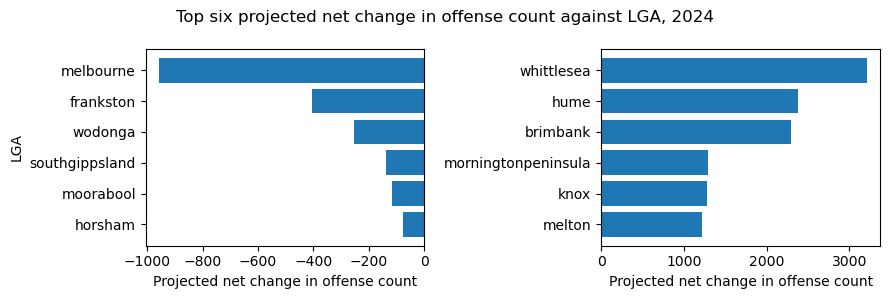

In [139]:
result = result1.copy()
result['delta'] = result['crime'] - result['last_crime']
result = pd.merge(result, population, how='inner', left_on='lga', right_on='LGA')
result['change'] = result['delta'] * result['Population'] / 100000
out = result.sort_values(by='delta')

positives = out[out['change'] > 0].nlargest(6, columns=['change']).sort_values(by='change', ascending=True)
negatives = out[out['change'] < 0].nsmallest(6,columns=['change']).sort_values(by='change', ascending=False)
fig, axes = plt.subplots(1,2,figsize=(9,3))
axes[0].barh(negatives['lga'], negatives['change'])
axes[1].barh(positives['lga'], positives['change'])
axes[0].set_ylabel('LGA')
axes[0].set_xlabel('Projected net change in offense count')
axes[1].set_xlabel('Projected net change in offense count')
fig.suptitle('Top six projected net change in offense count against LGA, 2024')
fig.tight_layout()

''

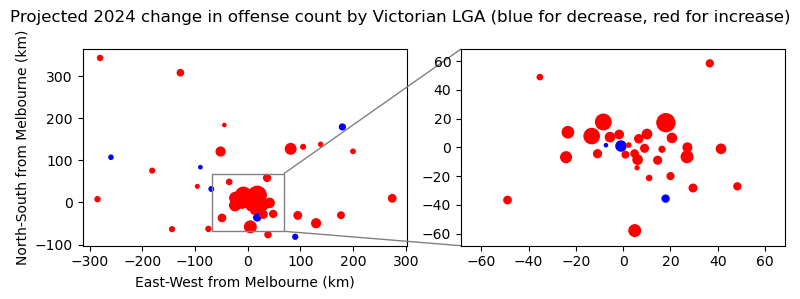

In [135]:
import matplotlib.patches as patches

from matplotlib.transforms import Bbox, TransformedBbox, blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 

fig, axes = plt.subplots(1,2, figsize=(8,3))
axes[0].scatter(
    result['locationx'], result['locationy'],
    s=np.abs(result['change'])/20 + 5,
      c=result['change'] > 0,
      cmap='bwr')

axes[0].set_xlabel('East-West from Melbourne (km)')
axes[0].set_ylabel('North-South from Melbourne (km)')

limit = result[(result['locationx'].abs() < 60) & (result['locationy'].abs() < 60)]
axes[1].scatter(
    limit['locationx'], limit['locationy'],
    s=np.abs(limit['change'])/20 + 5,
      c=limit['change'] > 0,
      cmap='bwr'
)
lim = max(np.max(np.abs(limit['locationx'])), np.max(np.abs(limit['locationy'])))+10

axes[1].set_xlim([-lim, lim])
axes[1].set_ylim([-lim, lim])
fig.suptitle('Projected 2024 change in offense count by Victorian LGA (blue for decrease, red for increase)')
fig.tight_layout()

def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

mark_inset(axes[0], axes[1], loc1a=2, loc1b=1, loc2a=3, loc2b=4, fc="none", ec="0.5")
;